In [2]:
import os

CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc'),
    'IMGS_ENTER':os.path.join('sys_images', 'enter'),
    'IMGS_EXIT':os.path.join('sys_images', 'exit'),
    'IMGS_PARKING_SPOTS':os.path.join('sys_images', 'parking_spots')
 }

files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

import object_detection

labels = [{'name':'placa', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')
        
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Define last checkpoint
for i in os.listdir(os.path.join(paths['CHECKPOINT_PATH'])):
    if 'ckpt' in i and '.index'in i:
        checkpoint = i
checkpoint = checkpoint[:checkpoint.find('.')]
print(checkpoint)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], checkpoint)).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

detection_threshold = 0.2

def prepareIMG(image):
    img = cv2.imread(image)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections
                ,detections['detection_boxes']
                ,detections['detection_classes']+label_id_offset
                ,detections['detection_scores']
                ,category_index
                ,use_normalized_coordinates=True
                ,max_boxes_to_draw=3
                ,min_score_thresh=detection_threshold
                ,agnostic_mode=False)
    
    plt.imshow(image_np_with_detections)
    return image_np, detections

import easyocr

def ocr(image, detections, detection_threshold, value):
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        crop = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        gray_image = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        (thresh, binary) = cv2.threshold(gray_image, value, 255, cv2.THRESH_BINARY_INV)
        reader = easyocr.Reader(['en'], gpu=True, verbose=False)
        ocr_result = reader.readtext(binary
                                   , allowlist = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
                                   , text_threshold = 0
                                   , low_text = 0.50
                                   , link_threshold  = 0.3
                                   , mag_ratio = 0.9
                                   , detail = 0
                                   , paragraph = 1)
        return (ocr_result)
    
def open_gate():
    print("Catraca aberta")

similar_number_to_char = {
    '1':'I',
    '2':'Z',
    '3':'B',
    '4':'A',
    '5':'S',
    '6':'G',
    '7':'T',
    '8':'B',
    '9':'J'
}  

similar_char_to_number = {
    'A':'4',
    'B':'8',
    'C':'6',
    'D':'0',
    'E':'8',
    'F':'6',
    'G':'6',
    'H':'8',
    'I':'1',
    'J':'9',
    'K':'4',
    'L':'1',
    'M':'0',
    'N':'0',
    'O':'0',
    'P':'9',
    'Q':'0',
    'R':'8',
    'S':'5',
    'T':'7',
    'U':'0',
    'V':'7',
    'W':'8',
    'X':'8',
    'Y':'7',
    'Z':'8'
}  
 
def format_ocr(ocr_result):
    for result in ocr_result:
        result = result.replace(' ','')
        
        if len(result) == 7:
            #FORMATO CLASSICO ABC1234
            #FORMATO MERCOSUL ABC1D23
            #CHECAGEM         1234x56

            char0 = str(result[0])
            char1 = str(result[1])
            char2 = str(result[2])
            char3 = str(result[3])
            char4 = str(result[4])
            char5 = str(result[5])
            char6 = str(result[6])

            if char0 in("0123456789"):
                try:
                    char0 = similar_number_to_char[char0]
                except: pass          
            if char1 in("0123456789"):
                try:
                    char1 = similar_number_to_char[char1]
                except: pass          
            if char2 in("0123456789"):
                try:
                    char2 = similar_number_to_char[char2]
                except: pass            
            if char3 not in("0123456789"):
                try:
                    char3 = similar_char_to_number[char3]
                except: pass            
            if char5 not in("0123456789"):
                try:
                    char5 = similar_char_to_number[char5]
                except: pass          
            if char6 not in("0123456789"):
                try:
                    char6 = similar_char_to_number[char6]
                except: pass

            return str(char0+char1+char2+char3+char4+char5+char6)
            

ckpt-21


In [2]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', '1087.jpg')

FBY2860


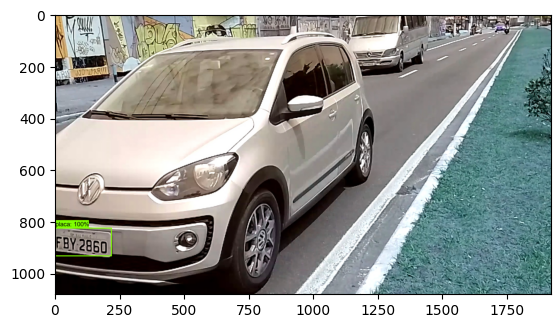

In [4]:
a = prepareIMG(IMAGE_PATH)
b = ocr(a[0], a[1], 0.2, 52)
c = format_ocr(b)
print(c)

# LOOPING

In [3]:
def monitoring_enter():
    while True:
        enter_image_list = os.listdir(paths['IMGS_ENTER'])
        if enter_image_list:
            prepared_IMG = prepareIMG(os.path.join(paths['IMGS_ENTER'], enter_image_list[0]))
            ocr_res = ocr(prepared_IMG[0], prepared_IMG[1], 0.2, 52)
            plate = format_ocr(ocr_res)
            print("ENTRADA: " + plate)
            
def monitoring_exit():
    while True:
        enter_image_list = os.listdir(paths['IMGS_EXIT'])
        if enter_image_list:
            prepared_IMG = prepareIMG(os.path.join(paths['IMGS_EXIT'], enter_image_list[0]))
            ocr_res = ocr(prepared_IMG[0], prepared_IMG[1], 0.2, 52)
            plate = format_ocr(ocr_res)
            print("SAIDA: " + plate)

def monitoring_spot():
    while True:
        enter_image_list = os.listdir(paths['IMGS_PARKING_SPOTS'])
        if enter_image_list:
            prepared_IMG = prepareIMG(os.path.join(paths['IMGS_PARKING_SPOTS'], enter_image_list[0]))
            ocr_res = ocr(prepared_IMG[0], prepared_IMG[1], 0.2, 52)
            plate = format_ocr(ocr_res)
            print("VAGAS - [VAGA: " + enter_image_list[0].replace('.jpg','') + " PLACA: " + plate + "]")

In [ ]:
monitoring_spot()

VAGAS - [VAGA: 1087 PLACA: FBY2860]
VAGAS - [VAGA: 1087 PLACA: FBY2860]
VAGAS - [VAGA: 1087 PLACA: FBY2860]
VAGAS - [VAGA: 1087 PLACA: FBY2860]
VAGAS - [VAGA: 1087 PLACA: FBY2860]
VAGAS - [VAGA: 1087 PLACA: FBY2860]
VAGAS - [VAGA: 1087 PLACA: FBY2860]
VAGAS - [VAGA: 1087 PLACA: FBY2860]
VAGAS - [VAGA: 1087 PLACA: FBY2860]
VAGAS - [VAGA: 1087 PLACA: FBY2860]
VAGAS - [VAGA: 1087 PLACA: FBY2860]
VAGAS - [VAGA: 1087 PLACA: FBY2860]
VAGAS - [VAGA: 1087 PLACA: FBY2860]
VAGAS - [VAGA: 1087 PLACA: FBY2860]


In [ ]:
if os.listdir(paths['IMGS_ENTER']):
    print('c')

In [ ]:
a = prepareIMG(os.path.join(paths['IMGS_ENTER'], ))
os.path.join(paths['IMGS_ENTER'],'test.jpg')